In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: ______________________
- PRN : ______________________
- Date: ______________________

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [1]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('../','input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

N_SAMPLE = 1000
NOISE = 0.2
TEST_SIZE = 0.2
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [3]:
###-----------------
### Hyper Parameters
###-----------------

EPOCH = 25 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 16 # mini batch size (number of rows)

PATIENCE = 20                                            
LR_FACTOR = 0
LR_PATIENCE = 10

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [4]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

data_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)


<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [5]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [6]:
# Sample data plot: Display a grid of images from the dataset aking with their labels
n_rows = 8 # Number of rows to display in the grid 
n_cols = 8 # Number of columns to display in the grid


In [7]:
# Randomly sample 'n_rows n_cols images from the dataset 
plot_df = data_df.sample(n=n_rows*n_cols)
plot_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
28815,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5819,0,0,0,0,0,0,0,0,0,37,...,28,103,1,0,0,0,0,0,0,0
44218,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8746,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12352,2,0,0,0,0,0,0,0,0,0,...,1,1,0,0,136,180,120,0,0,0


In [8]:
plot_df.shape

(64, 785)

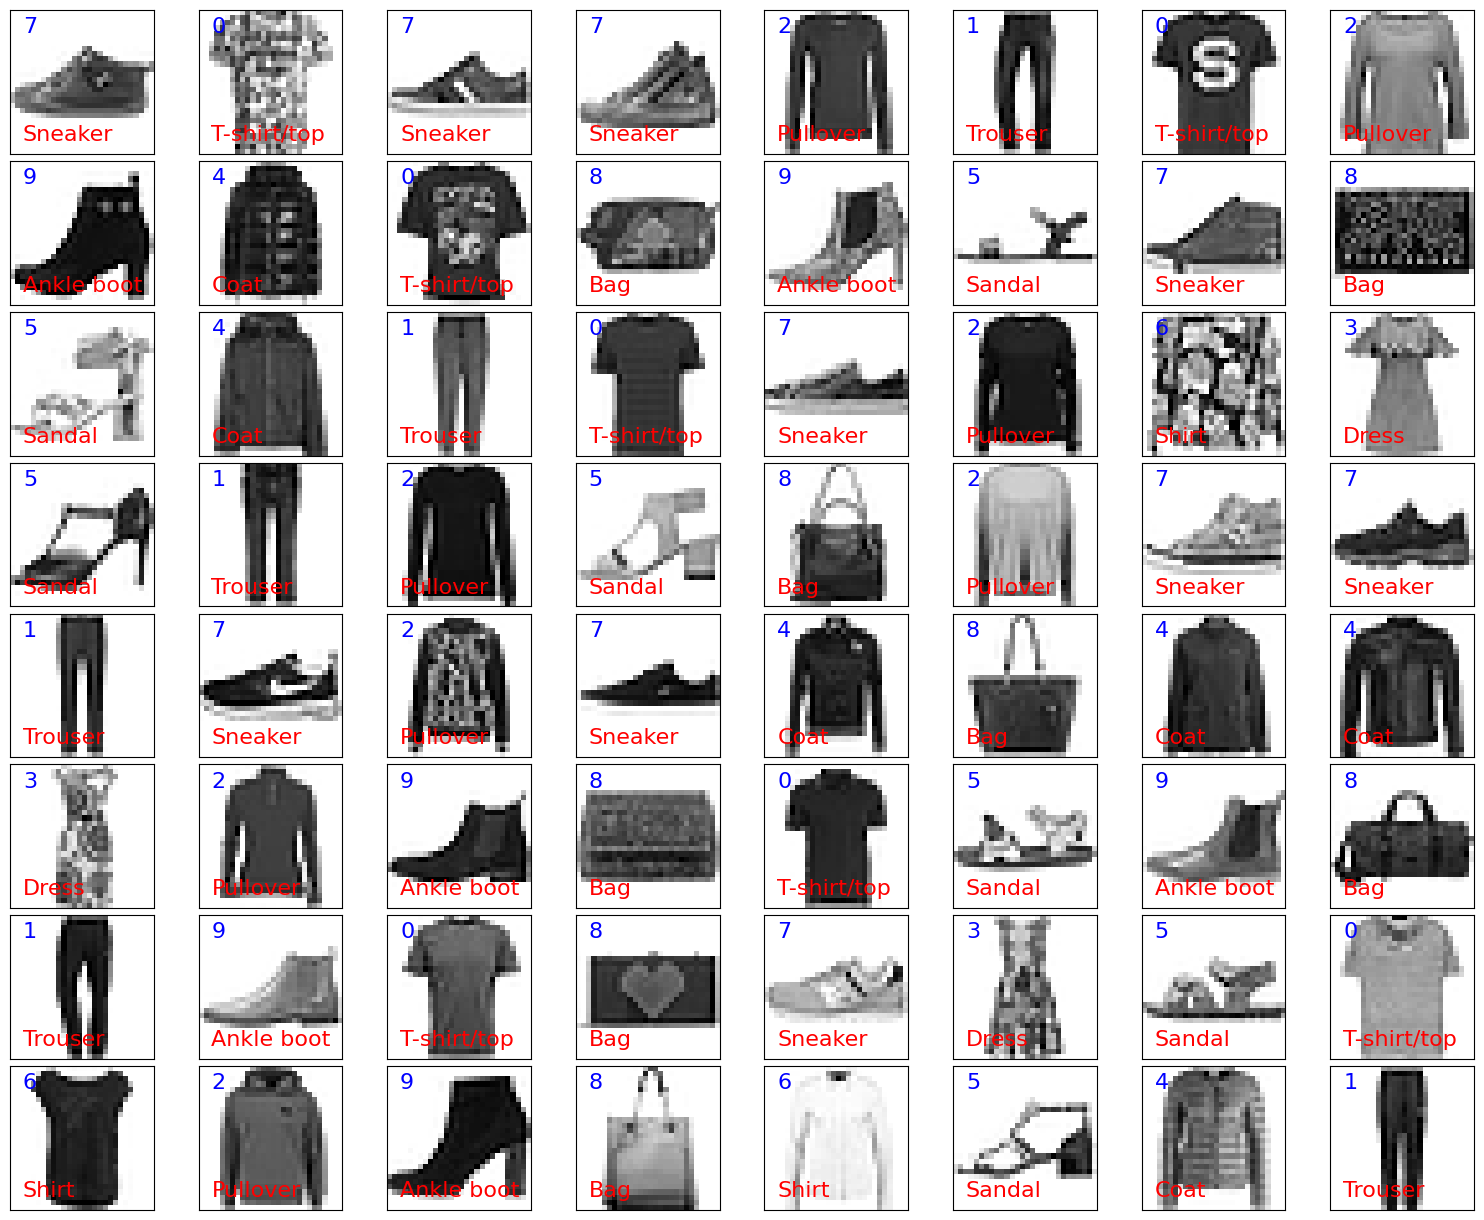

In [9]:
# Create a new figure for the grid of images with a specified size 
fig = plt.figure(figsize=(15, 12))

# Adjust spacing between subplots to eliminate gaps
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Initialize subplot index
i = 0

# Iterate through each row of the sampled DataFrame
for idx, row in plot_df.iterrows():
    i += 1 # Increment subplot index

    # Reshape the row values (excluding the first column) inte 26x28 matrix (ima dime 
    image = row.values[1:].reshape(28, 28)

    # Add a subplot to the figure at the 'i'th position in the grid 
    ax = fig.add_subplot(n_rows, n_cols, i, xticks=[], yticks=[]) # No ticks for a clean

    #Display the image on the subplot using a binary colormap
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')

    #Add the numeric label of the image in blue text at a specific position
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=16)

    # Add the class name of the image in red text below the numeric label
    ax.text(2, 25, class_names[row.iloc[0]], color='r', fontsize=16)

# Display the entire grid of images
plt.show()


In [10]:
for col in data_df.columns:
    unq = data_df[col].unique()
    print(f"\n{col} : Len:{len(unq)} unique vals ({unq})")


label : Len:10 unique vals ([2 9 6 0 3 4 5 8 7 1])

pixel1 : Len:8 unique vals ([ 0 14  7  3 16  1  4  2])

pixel2 : Len:17 unique vals ([ 0  1  3 10  6  2  7  5 16 14 13  9 34 15  4 11 36])

pixel3 : Len:27 unique vals ([  0   2   1  10   3   6   4   5   7  56  34  32  16  14  78  25  13   9
   8  52  35  30  23  54 226  15 106])

pixel4 : Len:65 unique vals ([  0   1   5   2   3  20  46  87   4  16  12   6  64  36  52  13   7 164
 110  14  92 106 120 105  53  70   9  23  49  25  26  34 121  21  17  10
  41  18  28  80  56 144  22  54  55  50  90 150  19 109  83 132  48  11
  32 145  39  96  15  58   8  68  82 146  86])

pixel5 : Len:103 unique vals ([  0   2   4   1   5   3  26  14  39  62  15  16  84   7  88  41  65  17
  35  61  11  21  10   6  18 119 162 106  34  12 217  33  24  37  13 185
  38  71  73   9  40  56  68 171  89  97  91  23  59  42  77 103  29 148
 140  31  45 201   8  95 133  80  44  43  27  20  32  58 123  22 116  66
  60  53 145  85 100  54 210 166 113  19  28 22

In [9]:
#We will further split test df set in validation set and test set.

X_data = data_df.drop('label', axis=1).to_numpy()
y_data = data_df['label'].to_numpy()



In [10]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, stratify=y_data, random_state=RANDOM_STATE)
X_valid = test_df.drop('label', axis=1).to_numpy()
y_valid = test_df['label'].to_numpy()

X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((48000, 784), (12000, 784), (10000, 784), (48000,), (12000,), (10000,))

In [11]:
# Normalize the data between [0,1]

# X_train = X_train / 255.0
# X_test = X_test / 255.0
# X_valid = X_valid / 255.0

In [12]:
# Scaling data
scl_std = StandardScaler()
X_train = scl_std.fit_transform(X_train)
X_test = scl_std.transform(X_test)

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))


In [14]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

In [15]:
#Shuffle and batch daataset
# - By chaining these operations(shuffle and batch), dataset is first shuffled
# - and then divided into batches, making it ready for training

train_ds = train_ds.shuffle(buffer_size=train_shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=test_shape[0]).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(buffer_size=valid_shape[0]).batch(BATCH_SIZE)

In [16]:
# Optimize for preformance
# Cache the data to avoid redundant processing
# Repeat the daatset for multiple Epochs
# Prefetch the data to overlap preprocessing and model execution

train_ds = train_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [20]:
#Number of Neurons in Layers(say 5)
784/2

# L1 = 392, L2 = 196, L3 = 98, L4 = 49, L5 = 24, L6 = 10


392.0

In [21]:
# linearly decreasing number of neurons. First tune the activation function with different options like relu, leaky-relu, tanh, tf.nn.silu(swish)
# tanh activation: model is chasing noise
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],), name='input'), ## input layer with 33 neurons
    tf.keras.layers.Dense(392, activation='relu', name='dense1'), ## first hidden layer with 392 neurons and ReLU activation function
    #tf.keras.layers.Dense(196, activation='relu', name='dense2'), ## second hidden layer with 128 neurons and ReLU activation function
    #tf.keras.layers.Dense(98, activation='relu', name='dense3'), ## third hidden layer with 64 neurons and ReLU activation function
    #tf.keras.layers.Dense(49, activation='relu', name='dense4'), ## fourth hidden layer with 32 neurons and ReLU activation function
    tf.keras.layers.Dense(24, activation='relu', name='dense5'), ## fifth hidden layer with 24 neurons and ReLU activation function
    tf.keras.layers.Dense(10, name='output') ## output layer with 4 neurons and softmax activation function for multi-class classification
])

In [22]:
# define a loss function and then model.compile. Can tweak the optimizer later
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(loss=loss_fn,
              optimizer=adam_optimizer,
              metrics=['accuracy'])

In [23]:
# now fit the model
# history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, batch_size=BATCH_SIZE,  callbacks=[early_stopping], verbose=2)
history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, verbose=2)

# validation data automatically trains the model on the training data and test data for every epoch

Epoch 1/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8305 - loss: 0.4845 - val_accuracy: 0.8447 - val_loss: 0.4292
Epoch 2/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8668 - loss: 0.3670 - val_accuracy: 0.8668 - val_loss: 0.3739
Epoch 3/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8811 - loss: 0.3228 - val_accuracy: 0.8599 - val_loss: 0.4068
Epoch 4/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8909 - loss: 0.2911 - val_accuracy: 0.8734 - val_loss: 0.3669
Epoch 5/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8992 - loss: 0.2713 - val_accuracy: 0.8673 - val_loss: 0.3749
Epoch 6/20
3000/3000 - 10s - 3ms/step - accuracy: 0.9085 - loss: 0.2478 - val_accuracy: 0.8703 - val_loss: 0.3983
Epoch 7/20
3000/3000 - 10s - 3ms/step - accuracy: 0.9139 - loss: 0.2323 - val_accuracy: 0.8792 - val_loss: 0.3851
Epoch 8/20
3000/3000 - 10s - 3ms/step - accuracy: 0.9184 - loss: 0.2188 - val_accuracy: 0.8802 - val_loss: 0.3789
Epoch 9/20
3000/3000 - 10s - 3ms/step - accuracy: 0.9237 - loss: 0.2041 - val_accuracy: 

In [24]:
# history stats
hist_df = pd.DataFrame(history.history)
display(hist_df.tail())

,accuracy,loss,val_accuracy,val_loss
15,0.946688,0.150661,0.874667,0.513244
16,0.949875,0.135710,0.880583,0.501398
17,0.949792,0.141073,0.880333,0.509561
18,0.951271,0.134578,0.878500,0.536613
19,0.953625,0.128381,0.877167,0.518877


You must install pydot (`pip install pydot`) for `plot_model` to work.


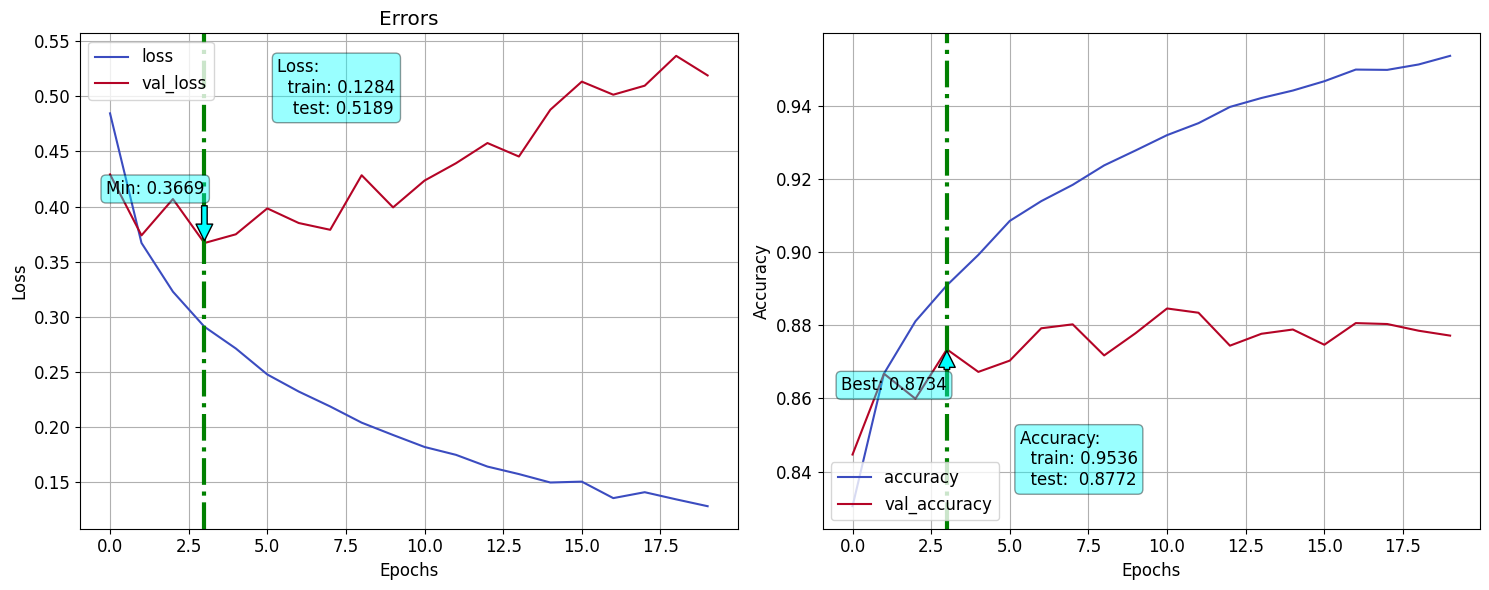

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)
fn_plot_tf_hist(hist_df=hist_df)

## Regularization(L2)

In [26]:
import gc
del model
gc.collect()

7950

In [27]:
# For Better Results: Regularization
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
regularizer = tf.keras.regularizers.L2(0.05) # tune reg lambda


In [28]:
## For Better Results: Chaining Layers

# inputs = tf.keras.Input(shape=(34,))
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, kernel_initializer=initializer, kernel_regularizer=regularizer, name='fc_1')(inputs) # Chaining
# x = tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, kernel_initializer=initializer, kernel_regularizer=regularizer, name='fc_2')(x) # Chaining
# x = tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, kernel_initializer=initializer, kernel_regularizer=regularizer, name='fc_3')(x) # Chaining
# x = tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, kernel_initializer=initializer, kernel_regularizer=regularizer, name='fc_4')(x) # Chaining
x = tf.keras.layers.Dense(24, activation=tf.keras.activations.relu, kernel_initializer=initializer, kernel_regularizer=regularizer, name='fc_5')(x) # Chaining
outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

In [29]:
# define a loss function and then model.compile. Can tweak the optimizer later
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(loss=loss_fn,
              optimizer=adam_optimizer,
              metrics=['accuracy'])

In [31]:
# now fit the model
# history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, batch_size=BATCH_SIZE,  callbacks=[early_stopping], verbose=2)
history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, verbose=2)

# validation data automatically trains the model on the training data and test data for every epoch

Epoch 1/20
3000/3000 - 12s - 4ms/step - accuracy: 0.7628 - loss: 1.3740 - val_accuracy: 0.7642 - val_loss: 0.8712
Epoch 2/20
3000/3000 - 10s - 3ms/step - accuracy: 0.7975 - loss: 0.7878 - val_accuracy: 0.7759 - val_loss: 0.7875
Epoch 3/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8050 - loss: 0.7241 - val_accuracy: 0.7828 - val_loss: 0.7448
Epoch 4/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8100 - loss: 0.6923 - val_accuracy: 0.7814 - val_loss: 0.7310
Epoch 5/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8120 - loss: 0.6750 - val_accuracy: 0.7782 - val_loss: 0.7315
Epoch 6/20
3000/3000 - 10s - 3ms/step - accuracy: 0.8132 - loss: 0.6637 - val_accuracy: 0.7767 - val_loss: 0.7309
Epoch 7/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8145 - loss: 0.6552 - val_accuracy: 0.7797 - val_loss: 0.7186
Epoch 8/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8148 - loss: 0.6470 - val_accuracy: 0.7752 - val_loss: 0.7202
Epoch 9/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8152 - loss: 0.6420 - val_accuracy: 

## Graphs: Regularization

In [32]:
# history stats
hist_df = pd.DataFrame(history.history)
display(hist_df.tail())

,accuracy,loss,val_accuracy,val_loss
15,0.816312,0.625723,0.770833,0.730402
16,0.816167,0.625565,0.771833,0.727949
17,0.815542,0.624807,0.775083,0.723680
18,0.816146,0.622720,0.771917,0.723307
19,0.815938,0.622338,0.779000,0.711395


In [33]:
# print("Epochs: ", EPOCHS)
# fig, ax = plt.subplots(1,2)

# hist_df.plot(y=['loss', 'val_loss'], ax=ax[0])
# hist_df.plot(y=['accuracy', 'val_accuracy'], ax=ax[1])

In [34]:
# del data_df

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


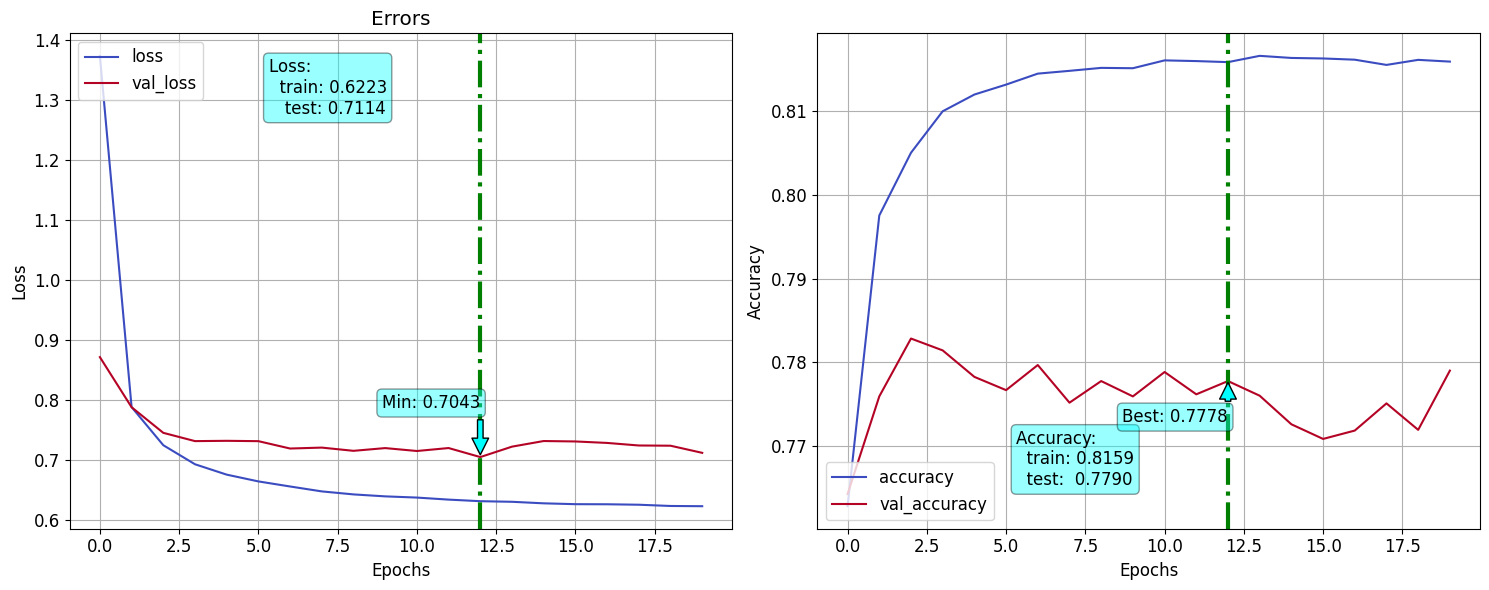

In [36]:
fn_plot_tf_hist(hist_df=hist_df)

*Without Normalizing : 30 Epochs*<br>
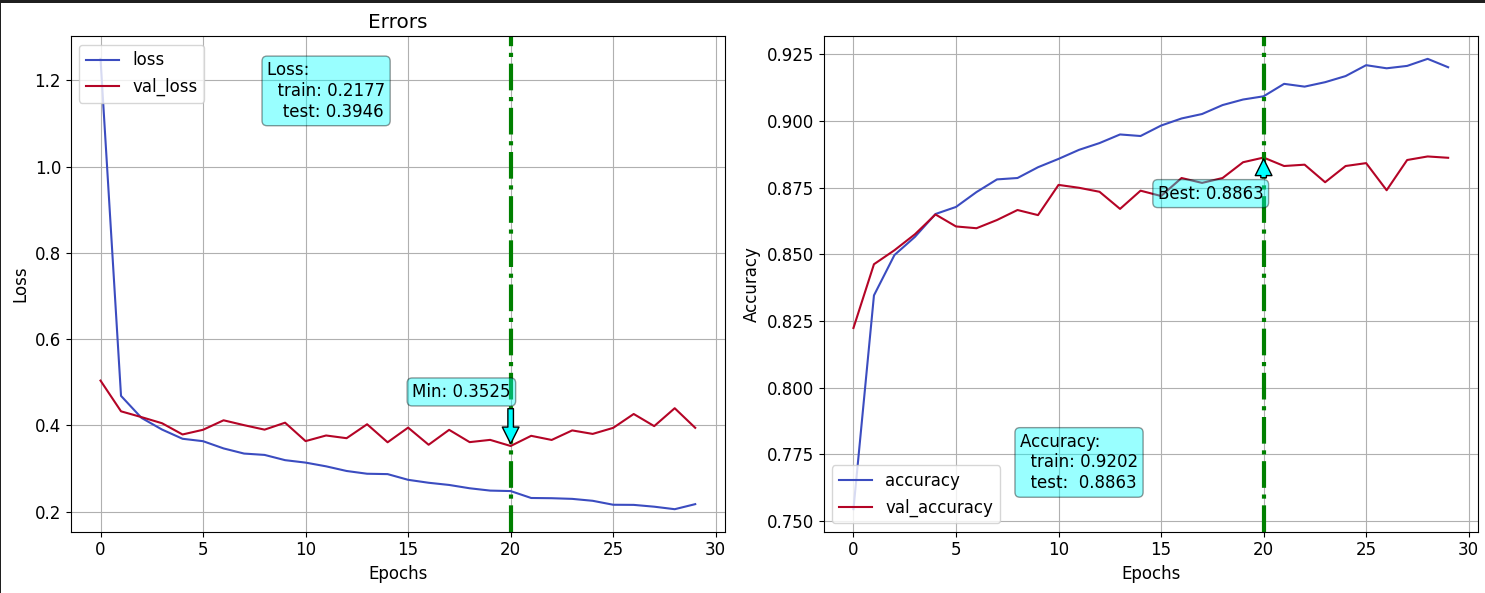

## Batch Normalization(BatchNorm)

In [37]:
import gc
del model
gc.collect()

10664

In [ ]:
## For Better Results: Batch Normalization

# inputs = tf.keras.Input(shape=(34,))
inputs = tf.keras.Input(shape=(X_train.shape[1],))

x = tf.keras.layers.Dense(392, kernel_initializer=initializer, name='fc_1')(inputs) # Chaining
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(196, kernel_initializer=initializer, name='fc_2')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(98, kernel_initializer=initializer, name='fc_3')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(49, kernel_initializer=initializer, name='fc_4')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

x = tf.keras.layers.Dense(24, kernel_initializer=initializer, name='fc_5')(x) # Chaining
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation='relu')(x)

outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

In [39]:
# ## For Better Results: Batch Normalization
# # Taking only 2 inner layers for faster execution

# # inputs = tf.keras.Input(shape=(34,))
# inputs = tf.keras.Input(shape=(X_train.shape[1],))

# # Set 1:
# x = tf.keras.layers.Dense(26,
#                           #activation=tf.keras.activations.relu,
#                           kernel_initializer=initializer,
#                           #kernel_regularizer=regularizer,
#                           name='fc_1')(inputs) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

# # Set 2:
# x = tf.keras.layers.Dense(18,
#                           # activation=tf.keras.activations.relu,
#                           kernel_initializer=initializer, name='fc_2')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)


# outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining

# model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

In [40]:
# define a loss function and then model.compile. Can tweak the optimizer later
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(loss=loss_fn,
              optimizer=adam_optimizer,
              metrics=['accuracy'])


In [41]:
# now fit the model
# history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, batch_size=BATCH_SIZE,  callbacks=[early_stopping], verbose=2)
history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, verbose=2)

# validation data automatically trains the model on the training data and test data for every epoch

Epoch 1/20
3000/3000 - 14s - 5ms/step - accuracy: 0.8133 - loss: 0.5459 - val_accuracy: 0.8553 - val_loss: 0.3935
Epoch 2/20
3000/3000 - 12s - 4ms/step - accuracy: 0.8592 - loss: 0.3911 - val_accuracy: 0.8652 - val_loss: 0.3620
Epoch 3/20
3000/3000 - 12s - 4ms/step - accuracy: 0.8807 - loss: 0.3330 - val_accuracy: 0.8736 - val_loss: 0.3520
Epoch 4/20
3000/3000 - 12s - 4ms/step - accuracy: 0.8961 - loss: 0.2898 - val_accuracy: 0.8796 - val_loss: 0.3459
Epoch 5/20
3000/3000 - 13s - 4ms/step - accuracy: 0.9093 - loss: 0.2513 - val_accuracy: 0.8801 - val_loss: 0.3482
Epoch 6/20
3000/3000 - 13s - 4ms/step - accuracy: 0.9224 - loss: 0.2178 - val_accuracy: 0.8812 - val_loss: 0.3624
Epoch 7/20
3000/3000 - 13s - 4ms/step - accuracy: 0.9320 - loss: 0.1905 - val_accuracy: 0.8805 - val_loss: 0.3707
Epoch 8/20
3000/3000 - 13s - 4ms/step - accuracy: 0.9411 - loss: 0.1663 - val_accuracy: 0.8789 - val_loss: 0.4025
Epoch 9/20
3000/3000 - 12s - 4ms/step - accuracy: 0.9484 - loss: 0.1459 - val_accuracy: 

In [ ]:
# history stats
hist_df = pd.DataFrame(history.history)
display(hist_df.tail())

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


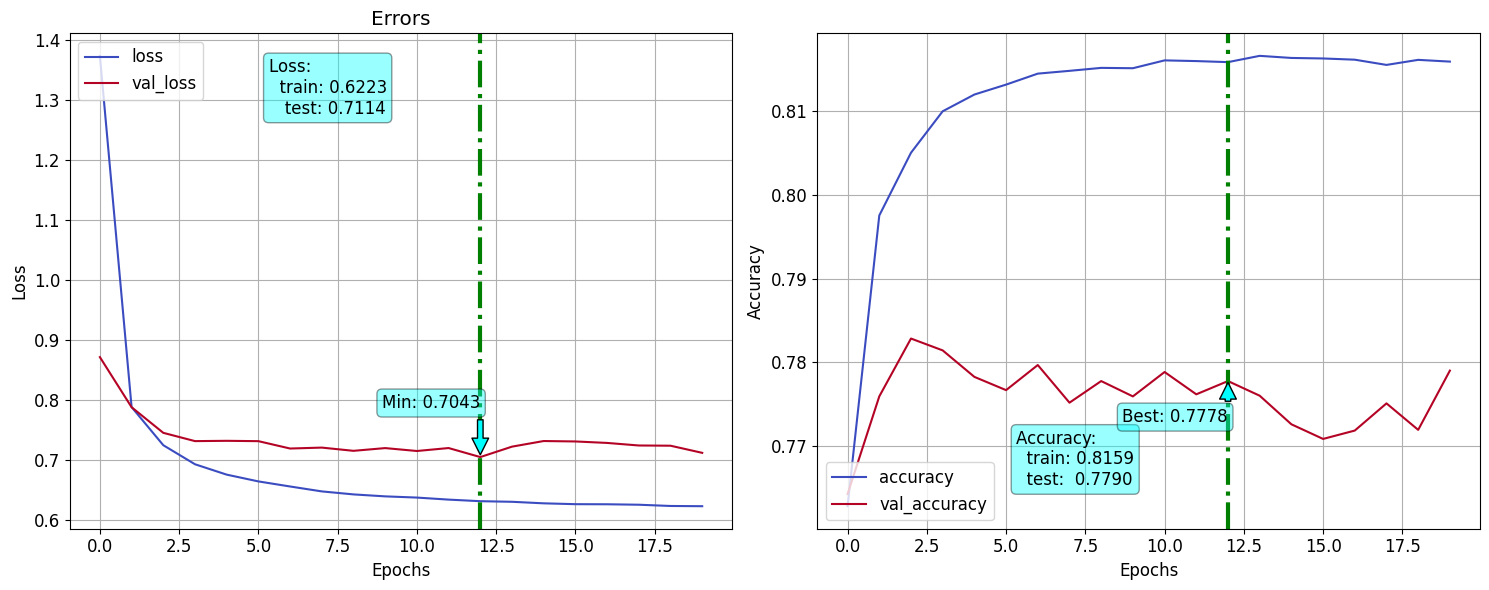

In [43]:
fn_plot_tf_hist(hist_df=hist_df)

### Batch Processing: Use Bias=False

In [44]:
import gc
del model
gc.collect()

10178

In [45]:
## For Better Results: Chaining Layers

# inputs = tf.keras.Input(shape=(34,))
inputs = tf.keras.Input(shape=(X_train.shape[1],))

x = tf.keras.layers.Dense(392, kernel_initializer=initializer, use_bias=False, name='fc_1')(inputs) # Chaining
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(196, kernel_initializer=initializer, use_bias=False, name='fc_2')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(98, kernel_initializer=initializer, use_bias=False, name='fc_3')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(49, kernel_initializer=initializer, use_bias=False, name='fc_4')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

x = tf.keras.layers.Dense(24, kernel_initializer=initializer, use_bias=False, name='fc_5')(x) # Chaining
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation='relu')(x)

outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

In [ ]:
# ## For Better Results: Batch Normalization
# # Taking only 2 inner layers for faster execution

# # inputs = tf.keras.Input(shape=(34,))
# inputs = tf.keras.Input(shape=(X_train.shape[1],))

# # Set 1
# x = tf.keras.layers.Dense(26, 
# #activation=tf.keras.activations.relu,
# kernel_initializer=initializer, use_bias=False,
# #kernel_regularizer=regularizer,
# name='fc_1')(inputs) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)

# # Set 2
# x = tf.keras.layers.Dense(18,
#                           # activation=tf.keras.activations.relu,
#                           use_bias=False,
#                           kernel_initializer=initializer, name='fc_2')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='relu')(x)


# outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining

# model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

In [47]:
# define a loss function and then model.compile. Can tweak the optimizer later
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(loss=loss_fn,
              optimizer=adam_optimizer,
              metrics=['accuracy'])


In [48]:
# now fit the model
# history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, batch_size=BATCH_SIZE,  callbacks=[early_stopping], verbose=2)
history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, verbose=2)

# validation data automatically trains the model on the training data and test data for every epoch

Epoch 1/20
3000/3000 - 13s - 4ms/step - accuracy: 0.8131 - loss: 0.5541 - val_accuracy: 0.8571 - val_loss: 0.3936
Epoch 2/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8594 - loss: 0.3915 - val_accuracy: 0.8667 - val_loss: 0.3630
Epoch 3/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8801 - loss: 0.3327 - val_accuracy: 0.8713 - val_loss: 0.3576
Epoch 4/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8973 - loss: 0.2872 - val_accuracy: 0.8743 - val_loss: 0.3550
Epoch 5/20
3000/3000 - 11s - 4ms/step - accuracy: 0.9090 - loss: 0.2514 - val_accuracy: 0.8758 - val_loss: 0.3661
Epoch 6/20
3000/3000 - 11s - 4ms/step - accuracy: 0.9222 - loss: 0.2195 - val_accuracy: 0.8768 - val_loss: 0.3766
Epoch 7/20
3000/3000 - 11s - 4ms/step - accuracy: 0.9318 - loss: 0.1917 - val_accuracy: 0.8731 - val_loss: 0.3945
Epoch 8/20
3000/3000 - 11s - 4ms/step - accuracy: 0.9415 - loss: 0.1680 - val_accuracy: 0.8751 - val_loss: 0.4291
Epoch 9/20
3000/3000 - 11s - 4ms/step - accuracy: 0.9480 - loss: 0.1477 - val_accuracy: 

In [ ]:
# history stats
hist_df = pd.DataFrame(history.history)
display(hist_df.tail())

You must install pydot (`pip install pydot`) for `plot_model` to work.


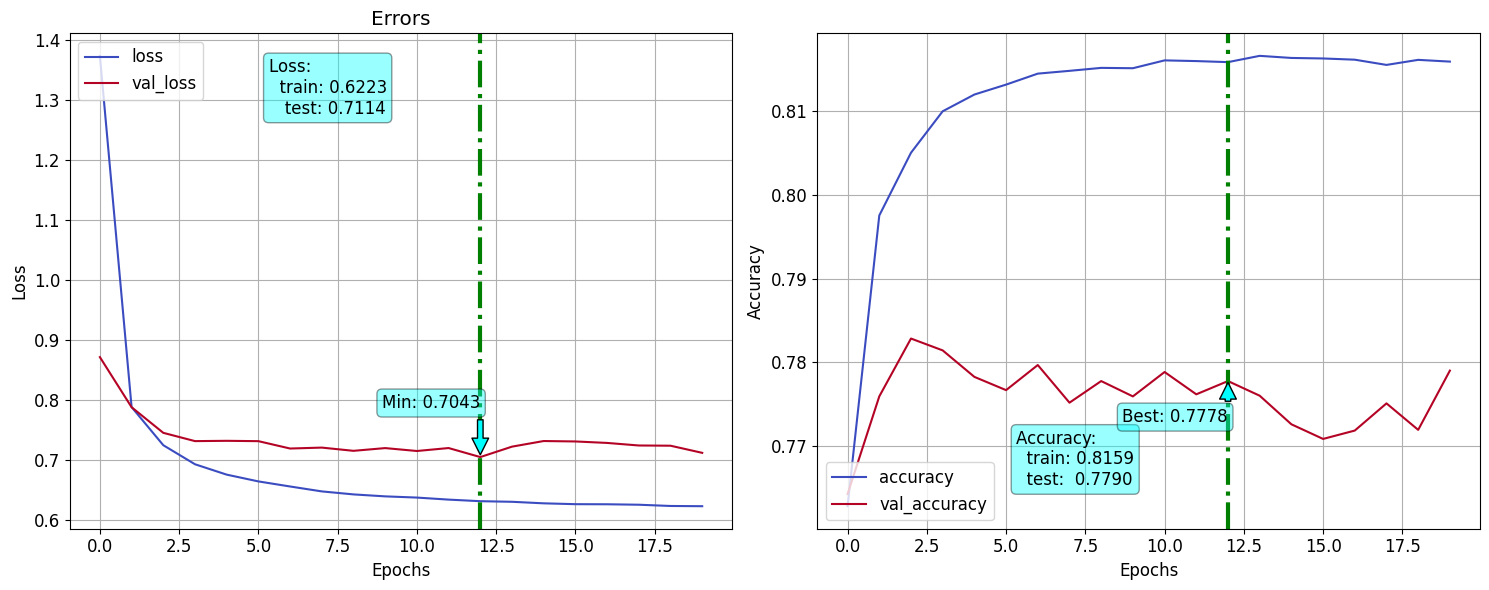

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)
fn_plot_tf_hist(hist_df=hist_df)

### Dropout

In [ ]:
import gc
del model
gc.collect()

In [50]:
DOR1 = 0.2
DOR2 = 0.3
DOR3 = 0.4

In [51]:
# For Better Results: Regularization
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#regularizer = tf.keras.regularizers.L2(0.05) # tune reg lambda


In [53]:
## For Better Results: Chaining Layers

inputs = tf.keras.Input(shape=(X_train.shape[1],))

x = tf.keras.layers.Dense(392, kernel_initializer=initializer, name='fc_1')(inputs) # Chaining
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(rate=DOR1)(x)

# x = tf.keras.layers.Dense(196, kernel_initializer=initializer, name='fc_2')(x) # Chaining
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(98, kernel_initializer=initializer, name='fc_3')(x) # Chaining
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(49, kernel_initializer=initializer, name='fc_4')(x) # Chaining
# x = tf.keras.layers.Activation(activation='relu')(x)

x = tf.keras.layers.Dense(24, kernel_initializer=initializer, name='fc_5')(x) # Chaining
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(rate=DOR3)(x)

outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

In [54]:
# define a loss function and then model.compile. Can tweak the optimizer later
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(loss=loss_fn,
              optimizer=adam_optimizer,
              metrics=['accuracy'])


In [55]:
# now fit the model
# history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, batch_size=BATCH_SIZE,  callbacks=[early_stopping], verbose=2)
history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, verbose=2)

# validation data automatically trains the model on the training data and test data for every epoch

Epoch 1/20
3000/3000 - 12s - 4ms/step - accuracy: 0.7169 - loss: 0.7987 - val_accuracy: 0.8260 - val_loss: 0.4751
Epoch 2/20
3000/3000 - 11s - 4ms/step - accuracy: 0.7743 - loss: 0.6264 - val_accuracy: 0.8466 - val_loss: 0.4329
Epoch 3/20
3000/3000 - 11s - 4ms/step - accuracy: 0.7891 - loss: 0.5765 - val_accuracy: 0.8492 - val_loss: 0.4220
Epoch 4/20
3000/3000 - 12s - 4ms/step - accuracy: 0.8043 - loss: 0.5436 - val_accuracy: 0.8547 - val_loss: 0.3977
Epoch 5/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8106 - loss: 0.5211 - val_accuracy: 0.8553 - val_loss: 0.4086
Epoch 6/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8176 - loss: 0.5062 - val_accuracy: 0.8673 - val_loss: 0.3800
Epoch 7/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8239 - loss: 0.4900 - val_accuracy: 0.8698 - val_loss: 0.3747
Epoch 8/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8272 - loss: 0.4771 - val_accuracy: 0.8707 - val_loss: 0.3813
Epoch 9/20
3000/3000 - 11s - 4ms/step - accuracy: 0.8277 - loss: 0.4725 - val_accuracy: 

In [56]:
# history stats
hist_df = pd.DataFrame(history.history)
display(hist_df.tail())

,accuracy,loss,val_accuracy,val_loss
15,0.850354,0.419345,0.872833,0.374271
16,0.850896,0.415699,0.878500,0.374942
17,0.850583,0.418645,0.875000,0.393145
18,0.853708,0.408690,0.876500,0.387413
19,0.853562,0.405751,0.878417,0.377888


You must install pydot (`pip install pydot`) for `plot_model` to work.


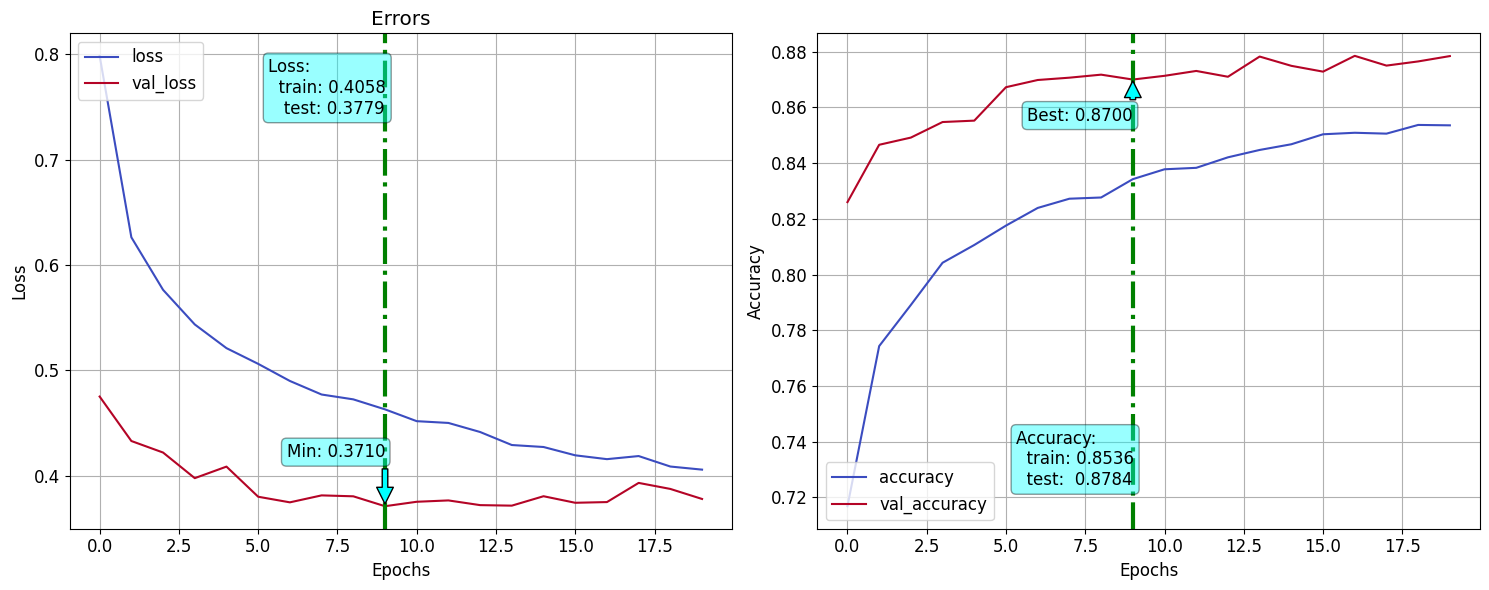

In [57]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)
fn_plot_tf_hist(hist_df=hist_df)

### Early stopping:
To decide the right number of EPOCH

In [18]:
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

In [20]:
DOR1=0.2
DOR2=0.3
DOR3=0.4

In [21]:
## For Better Results: Chaining Layers

inputs = tf.keras.Input(shape=(X_train.shape[1],))

x = tf.keras.layers.Dense(392, kernel_initializer=initializer, name='fc_1')(inputs) # Chaining
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(rate=DOR1)(x)

# x = tf.keras.layers.Dense(196, kernel_initializer=initializer, name='fc_2')(x) # Chaining
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(98, kernel_initializer=initializer, name='fc_3')(x) # Chaining
# x = tf.keras.layers.Activation(activation='relu')(x)

# x = tf.keras.layers.Dense(49, kernel_initializer=initializer, name='fc_4')(x) # Chaining
# x = tf.keras.layers.Activation(activation='relu')(x)

x = tf.keras.layers.Dense(24, kernel_initializer=initializer, name='fc_5')(x) # Chaining
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(rate=DOR3)(x)

outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining
model6 = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

In [22]:

chkptPath = os.path.join(modelDir, subDir, 'all_in.keras')

chkpt_cb = tf.keras.callbacks.ModelCheckpoint(chkptPath,
                                              monitor='val_loss',
                                              verbose=2,
                                              save_best_only=True)

In [23]:
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            verbose=2,
                                            patience=PATIENCE,
                                            restore_best_weights=True)

In [24]:
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            factor=LR_FACTOR,
                                            patience=LR_PATIENCE,
                                            verbose=True)

In [25]:
# define a loss function and then model.compile. Can tweak the optimizer later
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
model6.compile(loss=loss_fn,
              optimizer=adam_optimizer,
              metrics=['accuracy'])


In [26]:
# now fit the model
# history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, batch_size=BATCH_SIZE,  callbacks=[early_stopping], verbose=2)
# history = model.fit(train_ds, validation_data=[test_ds], epochs=EPOCH, verbose=2)

# validation data automatically trains the model on the training data and test data for every epoch

In [27]:
# history = model6.fit(x = X_train,y = y_train, epochs=EPOCH,
history6 = model6.fit(x = train_ds,
                     validation_data=[test_ds],
                     epochs=EPOCH,
                     batch_size=BATCH_SIZE,
                     callbacks=[chkpt_cb, es_cb, lr_cb],
                     verbose=2)


Epoch 1/20

Epoch 1: val_loss improved from inf to 0.47889, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 13s - 4ms/step - accuracy: 0.7078 - loss: 0.8000 - val_accuracy: 0.8242 - val_loss: 0.4789 - learning_rate: 1.0000e-03
Epoch 2/20

Epoch 2: val_loss improved from 0.47889 to 0.45070, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 11s - 4ms/step - accuracy: 0.7652 - loss: 0.6355 - val_accuracy: 0.8376 - val_loss: 0.4507 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: val_loss improved from 0.45070 to 0.41685, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 11s - 4ms/step - accuracy: 0.7878 - loss: 0.5726 - val_accuracy: 0.8510 - val_loss: 0.4169 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: val_loss improved from 0.41685 to 0.40903, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 11s - 4ms/step - accuracy: 0.7970 - loss: 0.5474 - val_accuracy: 0.8524 - val_loss: 0.4090 - learning_rate: 1.0000e-03
Epoch 5/20



,accuracy,loss,val_accuracy,val_loss,learning_rate
15,0.844063,0.421174,0.873083,0.380068,0.001
16,0.846729,0.408488,0.875750,0.381214,0.001
17,0.851646,0.400734,0.878667,0.371518,0.001
18,0.850750,0.400840,0.875000,0.367507,0.001
19,0.852625,0.399356,0.878083,0.382665,0.001


You must install pydot (`pip install pydot`) for `plot_model` to work.


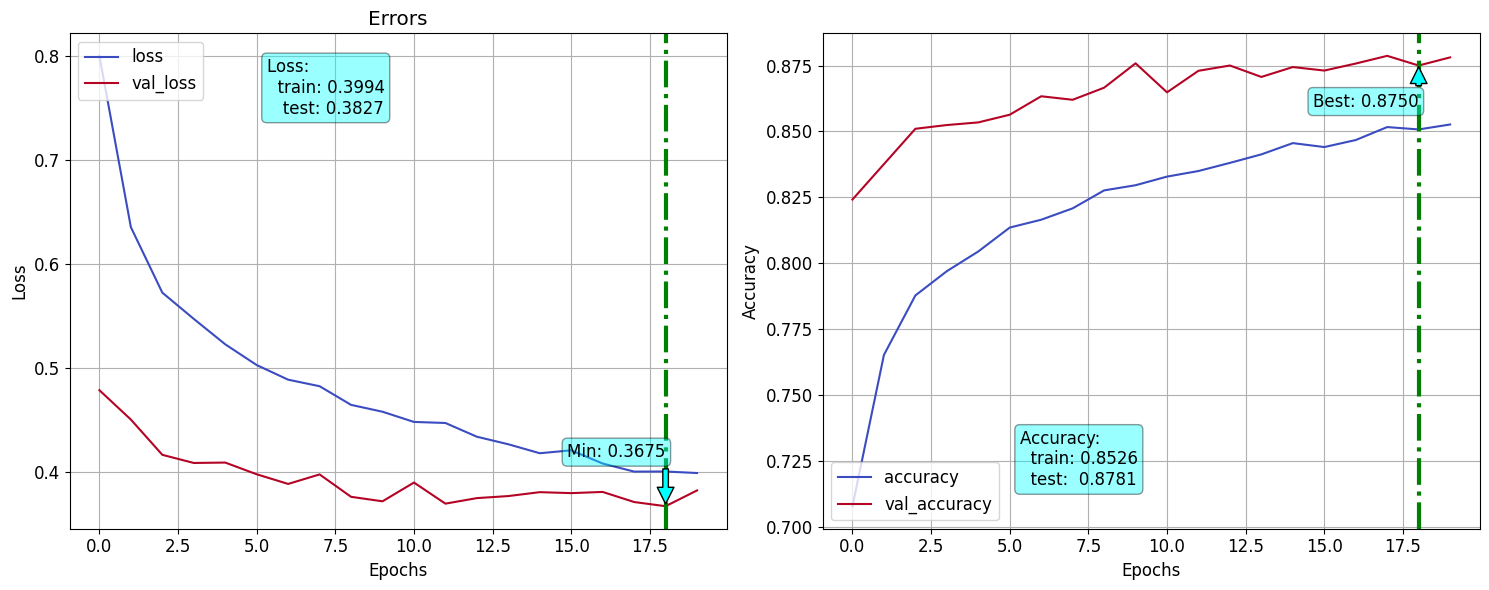

In [29]:
# history stats
hist_df6 = pd.DataFrame(history6.history)
display(hist_df6.tail())

tf.keras.utils.plot_model(model6, show_shapes=True, show_dtype=True, show_layer_names=True)
fn_plot_tf_hist(hist_df=hist_df6)

### Applying BatchNorm, Dropping, Early Stopping

In [17]:
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

DOR1=0.2
DOR2=0.3
DOR3=0.4
DOR4=0.5
DOR5=0.7

# DOR1=0.2
# DOR2=0.3
# DOR3=0.2
# DOR4=0.2
# DOR5=0.2


In [18]:
## For Better Results: Chaining Layers

inputs = tf.keras.Input(shape=(X_train.shape[1],))

x = tf.keras.layers.Dense(392, kernel_initializer=initializer, name='fc_1')(inputs) # Chaining
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(rate=DOR1)(x)

# x = tf.keras.layers.Dense(196, kernel_initializer=initializer, name='fc_2')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='leaky_relu')(x)
# x = tf.keras.layers.Dropout(rate=DOR2)(x)

x = tf.keras.layers.Dense(98, kernel_initializer=initializer, name='fc_3')(x) # Chaining
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(rate=DOR3)(x)

# x = tf.keras.layers.Dense(49, kernel_initializer=initializer, name='fc_4')(x) # Chaining
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation(activation='leaky_relu')(x)
# x = tf.keras.layers.Dropout(rate=DOR4)(x)

x = tf.keras.layers.Dense(24, kernel_initializer=initializer, name='fc_5')(x) # Chaining
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(rate=DOR5)(x)

outputs = tf.keras.layers.Dense(10, name='output')(x) # Chaining
# outputs = tf.keras.layers.Dense(10, activation='softmax', name='output')(x)

model_all = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')


In [19]:
chkptPath = os.path.join(modelDir, subDir, 'all_in.keras')

In [20]:
PATIENCE, LR_FACTOR, LR_PATIENCE

(20, 0, 10)

In [21]:
chkpt_cb = tf.keras.callbacks.ModelCheckpoint(chkptPath,
                                              monitor='val_loss',
                                              verbose=2,
                                              save_best_only=True)
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            verbose=2,
                                            patience=PATIENCE,
                                            # patience=16,
                                            restore_best_weights=True)
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            factor=LR_FACTOR,
                                            patience=LR_PATIENCE,
                                            verbose=True)

# lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=16, min_lr=8, verbose=1)

# define a loss function and then model.compile. Can tweak the optimizer later
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=ALPHA)

model_all.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=['accuracy'])


In [22]:

# history = model6.fit(x = X_train,y = y_train, epochs=EPOCH,
history_all = model_all.fit(x = train_ds,
                     validation_data=[test_ds],
                     epochs=EPOCH,
                     batch_size=BATCH_SIZE,
                     callbacks=[chkpt_cb, es_cb, lr_cb],
                     verbose=2)


Epoch 1/25

Epoch 1: val_loss improved from inf to 0.51546, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 18s - 6ms/step - accuracy: 0.6213 - loss: 1.1409 - val_accuracy: 0.8141 - val_loss: 0.5155 - learning_rate: 1.0000e-03
Epoch 2/25

Epoch 2: val_loss improved from 0.51546 to 0.45718, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 15s - 5ms/step - accuracy: 0.7103 - loss: 0.8697 - val_accuracy: 0.8320 - val_loss: 0.4572 - learning_rate: 1.0000e-03
Epoch 3/25

Epoch 3: val_loss improved from 0.45718 to 0.45002, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 15s - 5ms/step - accuracy: 0.7310 - loss: 0.8013 - val_accuracy: 0.8413 - val_loss: 0.4500 - learning_rate: 1.0000e-03
Epoch 4/25

Epoch 4: val_loss improved from 0.45002 to 0.41305, saving model to ../models\fashion_mnist\all_in.keras
3000/3000 - 14s - 5ms/step - accuracy: 0.7449 - loss: 0.7566 - val_accuracy: 0.8511 - val_loss: 0.4130 - learning_rate: 1.0000e-03
Epoch 5/25



,accuracy,loss,val_accuracy,val_loss,learning_rate
20,0.806313,0.555836,0.872500,0.367399,0.001
21,0.807500,0.544358,0.871500,0.367259,0.001
22,0.809438,0.538328,0.871500,0.375244,0.001
23,0.811729,0.532481,0.877083,0.359022,0.001
24,0.811750,0.531548,0.878917,0.364624,0.001


You must install pydot (`pip install pydot`) for `plot_model` to work.


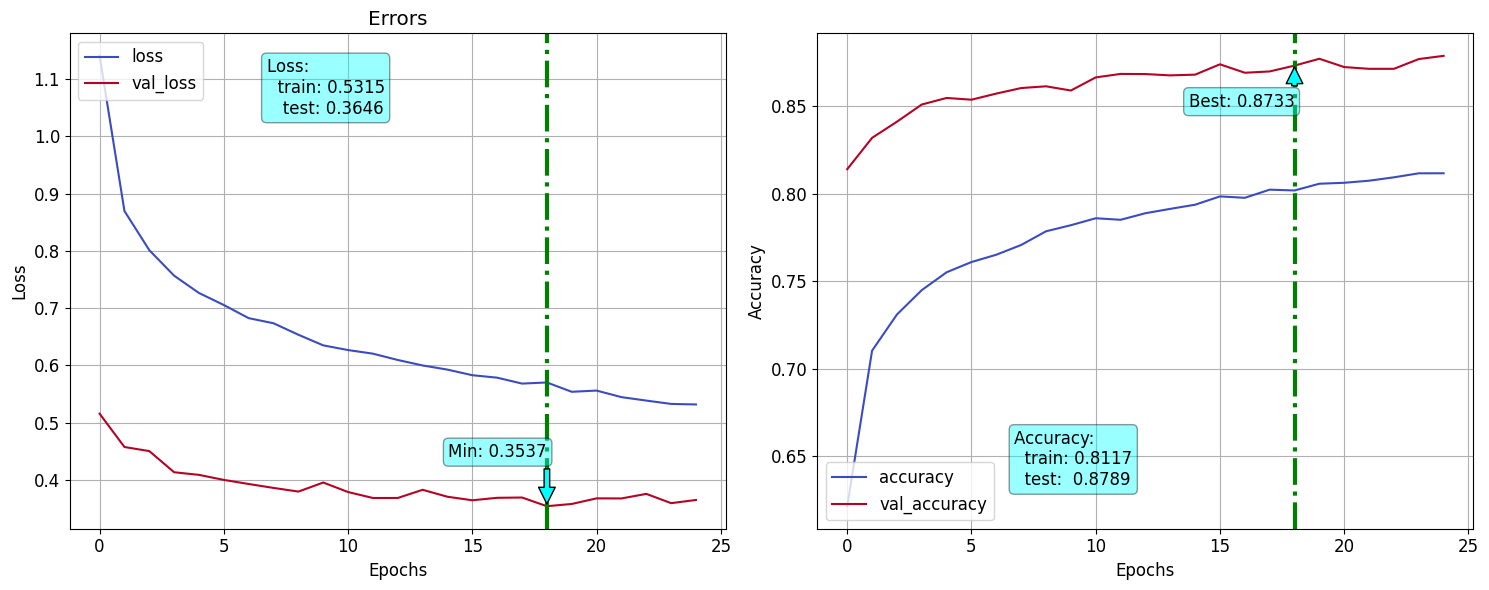

In [23]:
# history stats
hist_df_all = pd.DataFrame(history_all.history)
display(hist_df_all.tail())

tf.keras.utils.plot_model(model_all, show_shapes=True, show_dtype=True, show_layer_names=True)
fn_plot_tf_hist(hist_df=hist_df_all)

5 Layers: Lowering DROP rate<br>
EarlyStopping callback: (patience=16, restore_best_weights=True)<br>
LR_callback: (factor=0.5, patience=16, min_lr=8)<br>


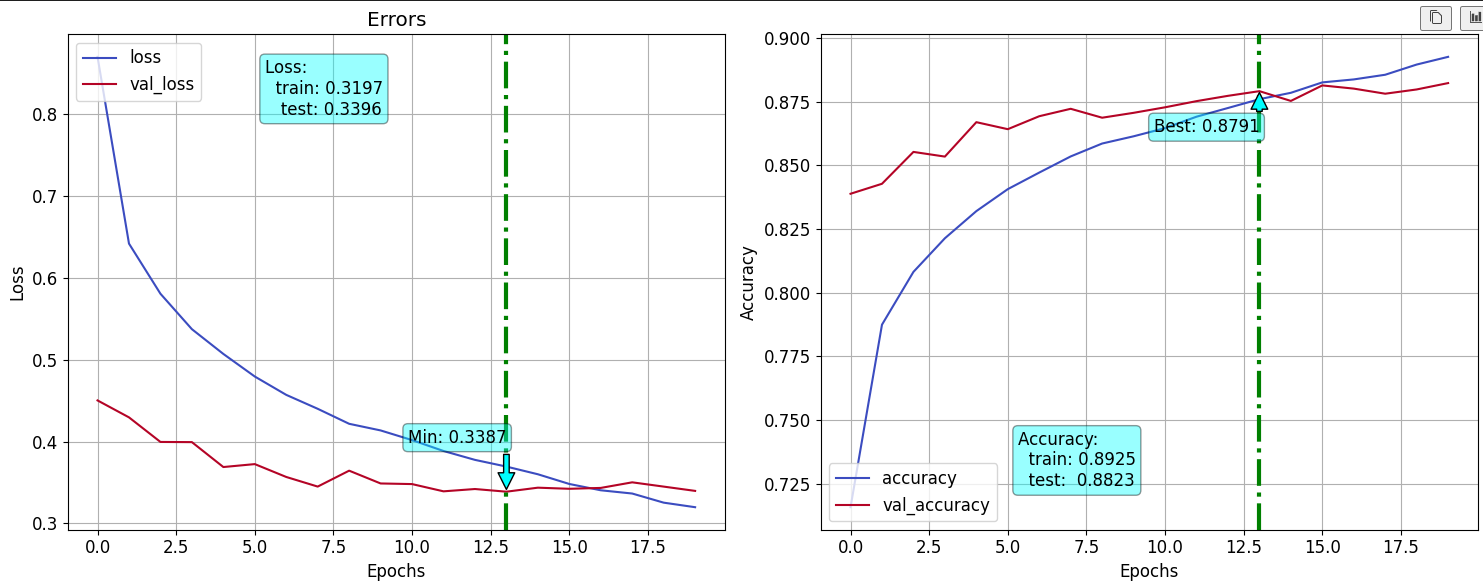

*5 Layers: Sir values*

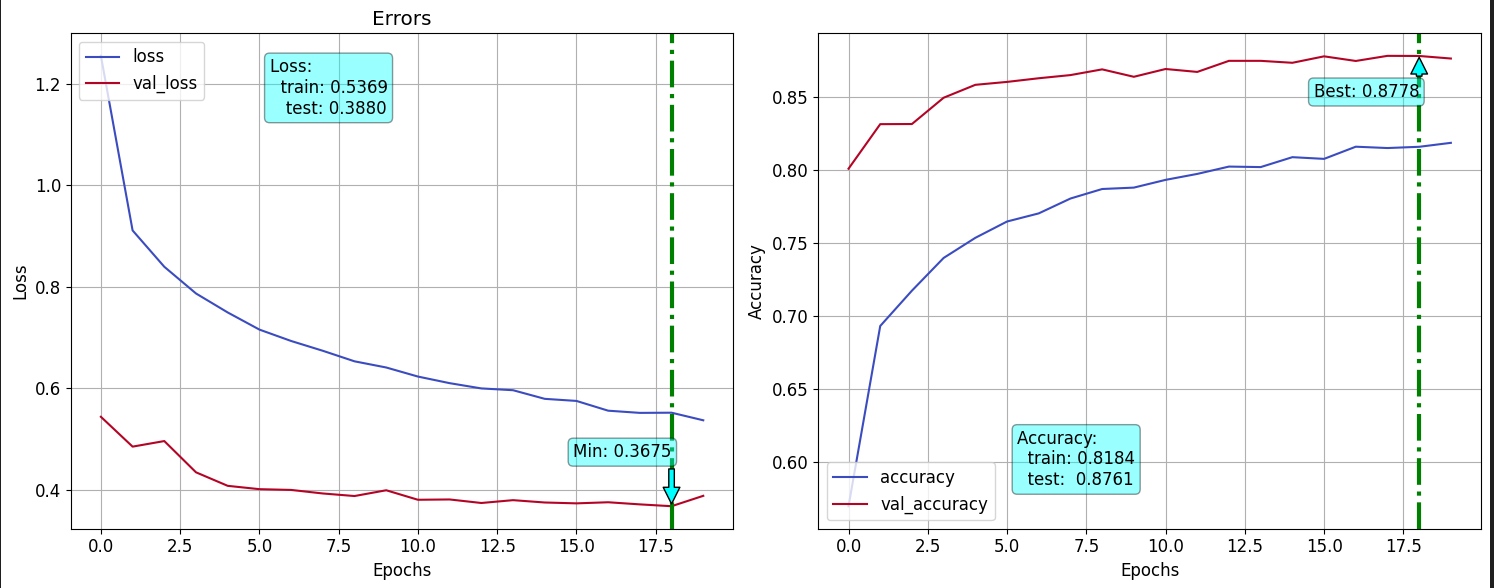

3 layers<br>
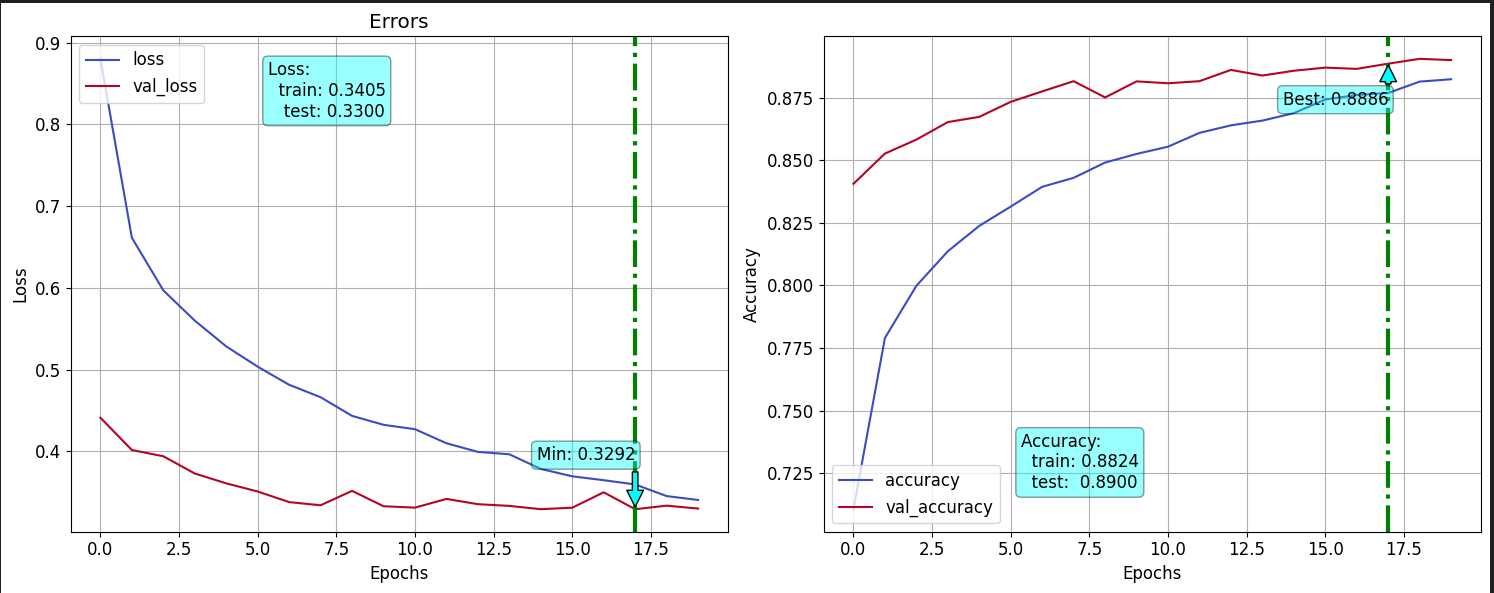